In [1]:
import os

try:
  
  from google.colab import files
  import shutil
  import zipfile

  def get_file(name, upload=True):
    if not os.path.exists(name) and upload:
      uploaded = files.upload()
      map = uploaded.values()
      if len(map) == 0:
        return False
      data = list(map)[0]
      with open(name, 'wb') as f:
        f.write(data)
    return os.path.exists(name)

  def get_path(filename, folder='./'):
      return filename

  def save_model(model, name):
    directory = '{}/{}/'.format('models', name)
    archive = '{}.zip'.format(name)
    if not os.path.exists(directory):
      os.makedirs(directory)
    model.save(os.path.join(directory, name))
    shutil.make_archive(name, 'zip', directory)
    print(archive)
    files.download(archive)

  def load_model(name, upload=True):
    archive = '{}.zip'.format(name)
    if get_file(archive, upload) == False:
      return None
    zip_ref = zipfile.ZipFile(archive, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    lda = models.LdaModel.load(name)
    return lda
  
except ImportError:
  
    def get_file(name, upload=True):
        return os.path.exists(name)

    def get_path(filename, folder='data'):
        return os.path.join('../{}/'.format(folder), filename)

    def save_model(model, name):
        directory = '{}/{}/'.format('../data/models', name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        model.save(os.path.join(directory, name))

    def load_model(name, upload=True):
        directory = '{}/{}/'.format('../data/models', name)
        if os.path.exists(os.path.join(directory, name)):
            return models.LdaModel.load(os.path.join(directory, name))
        return None

In [2]:
import numpy as np
import json

file = get_path("indexed_tweets.json")

get_file(file)

raw_data = json.load(open(file))
data = json.loads(raw_data)

In [3]:
tweets = []
for company in data:
    _, _, tweet_list = company
    tweets += list(map(lambda x: x[1], tweet_list))

tweets[:5]

[['inspires', 'share', 'us', 'will', 'donate', 'happy', 'holidays'],
 ['welcome', 'morgan', 'cmoconnect', 'event', 'ny'],
 ['talks', 'story', 'founded', 'evolved', 'cmoconnect'],
 ['ve',
  'using',
  'forever',
  'alot',
  'finally',
  'followed',
  'back',
  'live',
  'life',
  'go',
  'tour',
  'happy',
  'now',
  'xd'],
 ['ceo',
  'shantanu',
  'narayen',
  'joins',
  'exclusive',
  'interview',
  'next',
  'adbe',
  'earnings',
  'cloudcomputing',
  'cyberhack']]

In [4]:
import gensim

model = gensim.models.Word2Vec(tweets, size=100, window=5, min_count=5, workers=4, iter=20)

In [20]:
model.wv.similarity('woman', 'man')

0.4724087573328156

In [7]:
model.wv.most_similar_cosmul(positive=['work', 'helping'], negative=['help'])

[('working', 0.8853729367256165),
 ('geproud', 0.8033225536346436),
 ('worked', 0.8031169176101685),
 ('greatplacetowork', 0.7927882075309753),
 ('learning', 0.7707633972167969),
 ('permeates', 0.7644931674003601),
 ('tribute', 0.7607454657554626),
 ('valley', 0.7488634586334229),
 ('eve', 0.746041476726532),
 ('achievements', 0.7459911704063416)]

In [38]:
model.wv.most_similar_cosmul(positive=['today', 'last'], negative=['now'])

[('yesterday', 0.946369469165802),
 ('fun', 0.8890969157218933),
 ('girlspowertech', 0.8874157071113586),
 ('oracleschvisituk', 0.8774754405021667),
 ('fantastic', 0.8580135703086853),
 ('enjoyed', 0.8502044081687927),
 ('representing', 0.8485472798347473),
 ('formation17', 0.8475795984268188),
 ('wrapping', 0.8470105528831482),
 ('attended', 0.8468259572982788)]

In [49]:
model.wv.most_similar_cosmul(positive=['man', 'women'], negative=['woman'])

[('guys', 0.7390323877334595),
 ('meantime', 0.7184317708015442),
 ('brotha', 0.7152842283248901),
 ('phds', 0.7092193365097046),
 ('concert', 0.7061699032783508),
 ('moonshot', 0.6992079615592957),
 ('philips', 0.6954966187477112),
 ('people', 0.6882005333900452),
 ('laying', 0.6877174973487854),
 ('oz', 0.6863621473312378)]

In [8]:
embed = model.wv.vectors

In [9]:
from sklearn.manifold import TSNE

nb_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embed = tsne.fit_transform(embed[:nb_points])

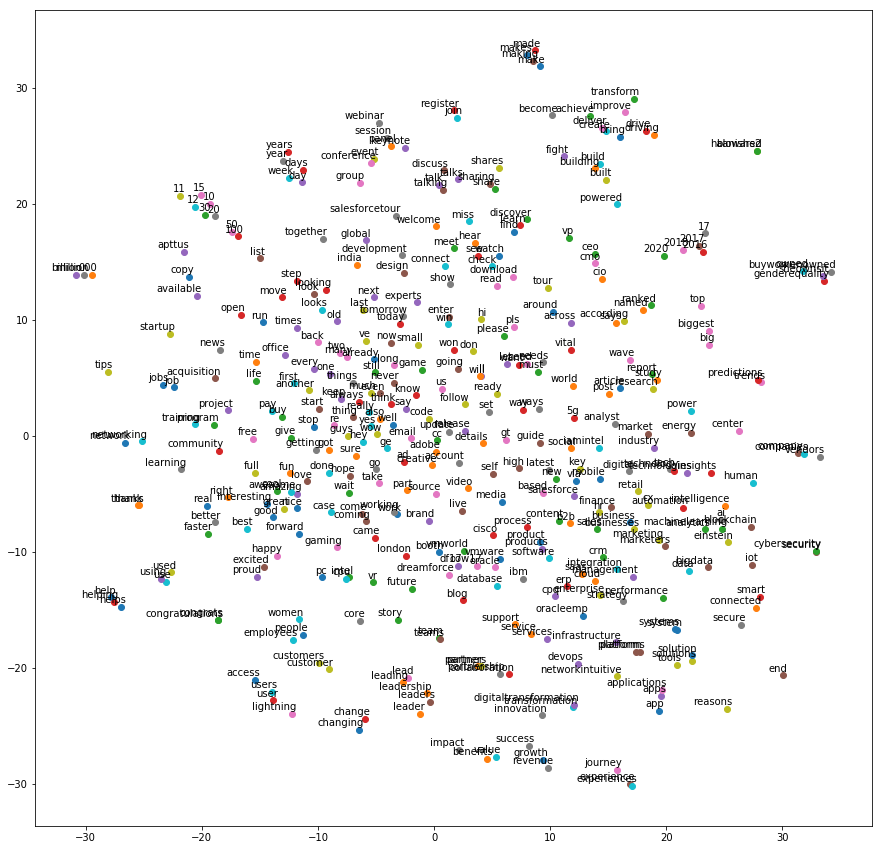

In [11]:
from matplotlib import pylab

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embed, model.wv.index2word[:nb_points])

In [ ]:
nb_clusters = 4

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=nb_clusters, n_jobs=-1, random_state=0)
idx = kmeans.fit_predict(embed)
word_centroid_list = list(zip(model.wv.index2word, idx))
word_centroid_list_sort = sorted(word_centroid_list, key=lambda x: x[1], reverse=False)

In [ ]:
for word_centroid in word_centroid_list_sort:
        print("{:20}{}".format(word_centroid[0], str(word_centroid[1])))

In [ ]:
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))